## Challenge statement

### Part 1: Prediction challenge

In [3]:
# df.head()

We start by importing the packages we need, reading in the dataset and doing some initial processing of the data. We will set the city ID as the index of the data frame and drop unecessary variables such as, 'City', 'Typology', 'Pollution Index'. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df = pd.read_excel('Cities.xls', index_col=0, skipinitialspace=True) # Read with excel index. 
# Skip all white-spaces.

df = df.set_index('cityID') # Remove the indices and use cityID as index.

# Drop unnecessary columns (that explicitly imply each other)
# cityID implies City
# clusterID implies Typology
# Pollution Index is restricted to be used in prediction.
col2drop = ['City', 'Typology', 'Pollution Index ']
# col2drop = ['City', 'Typology']



df.drop(col2drop, inplace=True, axis=1) # Typology <=> clusterID, City <=> cityID, 
# df.drop("Pollution Index", axis=1)
# df.info()
# df["Pollution Index"] 

In [5]:
print(df.shape)
df.head()

(331, 74)


,clusterID,Country,Car Modeshare (%),Public Transit Modeshare (%),Bicycle Modeshare (%),Walking Modeshare (%),Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,Subway Ridership per Capita,Subway Age (years),BRT Length (km),BRT System Length Density (per km),BRT Stations per Hundred Thousand Persons,BRT Fleet per Hundred Thousand Persons,BRT Annual Ridership per Capita,BRT Age (years),Bikeshare Stations,Bikeshare Stations per Hundred Thousand Persons,Bikeshare Number of Bikes,Bikeshare Bicycles per Hundred Thousand Persons,Bikeshare Age (years),Congestion (%),Congestion AM Peak (%),Congestion PM Peak (%),Traffic Index,Travel Time Index,Inefficiency Index,Population,Land Area (sq. km),Population Density (per sq. km),Population Change 1990 – 2000,Population Change 2000 – 2010,Population Change 2010 – 2020,Population Change 2020 – 2025,Urbanization Rate 2015 (%),Urbanization Rate Change 2015 – 2025 (pp),GDP per Capita (USD),Unemployment Rate (%),Cost of Living Index,Rent Index,Grocery Index,Restaurant Price Index,Local Purchasing Power Index,Gini Coefficient,Poverty Rate (%),Life Expectancy (years),Safety Index,Internet Penetration,Digital Penetration,Innovation Index,Smartphone Penetration (%),CO2 Emissions per Capita (metric tonnes),Street length total (m),Street Length Density (m/sq. km),Street Length Average (m),Intersection Count,Intersection Density (per sq. km),Degree Average,Streets per Node,Circuity,Self-Loop Proportion,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
cityID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
285,7,United States,85.0,6.1,0.3,2.6,0.66,8.5,24.9,0.013409,0.615385,6.417582,34,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,2.197802,NaN,0.00000,2.0,19.0,33.0,46.0,148.97,36.90,150.22,2275000,1857,1200,233673,332204,399059,195708,81.6,1.7,58789.0,7.20,77.33,48.58,76.48,78.28,150.69,0.443,22.9,78.8,31.19,81.0,0.78,45.0,72.0,14.300000,7468900.983,7.604833e+09,148.013337,28660.0,1018.199702,5.021972,2.869906,1.067736,0.007910,0.041018,0.160848,0.176867,0.360637,0.796264,0.355964,0.081956,0.180085,0.722163,0.425187
10,8,Australia,80.0,14.0,2,4.0,1.11,5.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,50,1.264223,600.0,15.17067,2.0,33.0,55.0,58.0,143.12,35.57,138.17,3955000,2543,1500,316060,462816,715525,350883,89.4,1.2,39358.0,5.50,79.04,44.30,72.93,76.07,139.62,NaN,NaN,82.0,60.23,86.9,0.74,50.0,77.0,10.200000,8636838.530,8.653670e+09,107.503591,48571.0,1001.948856,4.948413,2.876305,1.036985,0.001626,0.014489,0.060387,0.168335,0.363675,0.786174,0.397894,0.082267,0.333173,0.539355,0.558910
186,1,Niger,NaN,9.0,2,60.0,1.02,26.4,0.0,0.000000,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1435000,130,11100,248392,541978,960996,741379,18.7,3.5,427.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.6,61.8,NaN,2.4,0.04,NaN,NaN,0.106861,2134329.200,3.496995e+09,97.860119,13033.0,1638.451450,6.161297,3.187450,1.019423,0.000095,0.000000,0.036220,0.010915,0.343161,0.000000,0.273646,0.248398,0.655464,0.275605,0.410312
328,12,Vietnam,8.0,10.0,2,NaN,0.90,24.5,0.0,0.000000,0.000000,0.000000,0,14.5,NaN,0.143000,NaN,0.149000,1.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,160.60,40.78,189.18,7445000,868,8600,520495,1149423,1391900,608994,33.6,6.3,3425.0,6.84,41.73,17.15,37.25,22.72,23.47,0.340,5.4,76.0,54.64,50.1,0.31,35.0,35.0,1.700368,8079366.816,1.156634e+09,300.370541,15881.0,143.158938,5.205795,2.870473,1.097533,0.000921,0.022938,0.078028,0.084511,0.358868,0.157676,0.509057,0.292564,0.624623,0.666710,0.239113
67,12,China,21.7,54.7,NaN,NaN,1.16,18.8,0.0,0.000000,0.000000,0.000000,0,66.0,0.134146,2.537764,9.123867,34.441088,7.0,0,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,NaN

Taking a look at the data we notice that there are many values missing in many of the columns. It is not really feasible to simply get rid of all rows with missing values so we need to replace the values in some way. Two methods have been considered namely to, predict the values of each column one by one with a decision tree, and to replace the values in each column with the mean/ mode. It turned that predicting the missing values gave worse results than simply replacing the missing values with the columns mean/ mode.

The function below was created to easily replace all the missing values within the dataframe using the mean/ mode approach. The function also rescales the data with the MinMaxScaler() function from the sklearn library preprocessing. 


In [6]:
def replace_missing_val_rescale(df):
    
    df = df.replace(r'^\s*$', np.NaN, regex=True)
    # print("Initial dataframe shape [rows, columns]:", df.shape)
    n_NaN = df.isna().sum().sum()
    # print(n_NaN) # As you can see the total number of NaNs in the database 3199, so we need to impute.

    # Impute all NaNs over the database.

    df_int = df.select_dtypes(include='integer')
    df_float = df.select_dtypes(include='float')

    df_int = df_int.fillna(df.mode().iloc[0]) # Try using mean/mod for different columns.
    df_float = df_float.fillna(df.mean().iloc[0]) # Try using mean/mod for different columns.

    df[df_int.columns.values.tolist()] = df_int # Use mod for integers,
    df[df_float.columns.values.tolist()] = df_float # Use mean for floats

    # Drop taget variable
    df_targets = df['CO2 Emissions per Capita (metric tonnes)']
    df_inputs = df.drop(columns=['CO2 Emissions per Capita (metric tonnes)'])

    # Normalize data
    from sklearn import preprocessing
    x = df_inputs.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    x_unscaled =  min_max_scaler.inverse_transform(x_scaled)
    df_inputs = pd.DataFrame(x_scaled)

#     df_in_mean = df_inputs.mean()
#     df_in_min = df_inputs.min()
#     df_in_max = df_inputs.max()
    
#     df_in = (df_inputs - df_in_mean)/(df_in_max - df_in_min)
    
    assert df_inputs.isna().sum().sum() == 0, "ERROR!, There still contains NaN values in the df_inputs DataFrame"
    
    return df_inputs, df_targets


For the second segment of the prediction part we need to use only North and South American data points. So we already from beginning can prepare the data for that as seen below. 

In [7]:
# Get DataFrame for only South/ North America
country_list = ["United States", "Canada", "Mexico", "Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", "Peru", "Paraguay", "Suriname", "Uruguay", "Venezuela"] 
north_south_america = df[df.Country.isin(country_list)]
# print(north_south_america.head(5))
df2 = df.drop(["Country"], axis=1)
north_south_america = north_south_america.drop(["Country"], axis=1)

In [8]:
df_inputs, df_targets = replace_missing_val_rescale(df2)
# North and South America
df_inputs_nsa, df_targets_nsa = replace_missing_val_rescale(north_south_america)


Now the actual manipulation and analysis of the data can take place now that we have our rescaled and 'cleaned' data ready for action. 

An inital prediction was attempted without any processing of the data, but as expected a relativly low R^2 score was attained (almost 0.4). The initial idea to improve the score would be to try multiple prediction algorithms and to reduce the dimensionality of the dataset. 

Random forest regression, support vector regression and multilayer perceptron regression were all tested to predict the target variable. It turned out to be the multilayer perceptron model from the sklearn neural_network package which performed the best. As for dimensionality reduction, PCA analysis was used as well as utilizing the co-correlation and co-variance within the data set. It turned out to be that dropping columns of low variance (under a given threshold) produced the best result. Using the variance threshold method, a total of 44 columns were dropped, which means (as seen in the code outputs below) using 30 variables in the final model was enough to predict the target.     

In [9]:
# Drop columns with low variance. Low variance mean they dont change much and should not contribute much to the model.

from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# selector = VarianceThreshold(threshold=0.04)
# df_inputs = selector.fit_transform(df_inputs)
# # print(df_inputs.columns)
# df_inputs = pd.DataFrame(df_inputs)
# df_inputs.shape

In [10]:
# Perform the variance thresholding to drop low variance columns
print('shape before dimension reduction:', df_inputs.shape)
df_inputs = variance_threshold_selector(data=df_inputs, threshold=0.04)
print('shape after dimension reduction:', df_inputs.shape)

# Make sure same columns are slected for the North and South America data frame
print('shape before dimension reduction:',df_inputs_nsa.shape) 
df_inputs_nsa = df_inputs_nsa[list(df_inputs.columns)]
print('shape after dimension reduction:', df_inputs_nsa.shape)

shape before dimension reduction: (331, 72)
shape after dimension reduction: (331, 30)
shape before dimension reduction: (95, 72)
shape after dimension reduction: (95, 30)


In [11]:
train_perc = 0.75
tr_slice_ind = int(len(df)*0.75)+1

tr_target = df_targets.head(tr_slice_ind)
tr_inputs = df_inputs.head(tr_slice_ind)

ts_target = df_targets.tail(df_inputs.shape[0]-tr_slice_ind)
ts_inputs = df_inputs.tail(df_inputs.shape[0]-tr_slice_ind)

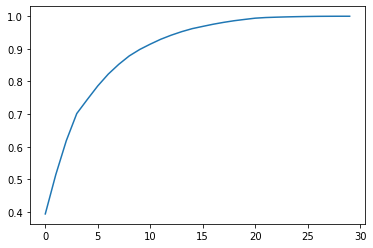

In [12]:
# Perform PCA
from sklearn.decomposition import PCA

pca = PCA()
# print(p_df.head())
# len(pca.components_)
shape_before = tr_inputs.shape
pca.fit(tr_inputs)
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]
plt.plot(range(len(expl)), cdf);
# print(cdf[:15]) # 15 most explaining components
# pca = PCA(n_components=10) # Looks to about how many components explains 95% of the total variance.
# tr_inputs = pca.fit_transform(tr_inputs) 
# tr_inputs = pd.DataFrame(tr_inputs)
# ts_inputs = pca.fit_transform(ts_inputs)
# ts_inputs = pd.DataFrame(ts_inputs)
# shape_after = tr_inputs.shape
# print("input shape before PCA: ", shape_before, "\n", "input shape after PCA:", shape_after)

In [13]:
# print(tr_inputs.shape)
# comps.head()
# tr_inputs.head(40)

In [14]:
# # Make sure all inputs have the same columns
# ts_in = ts_inputs[list(comps.columns)]
# df_inputs_nsa = df_inputs_nsa[list(tr_inputs.columns)]
# print(tr_inputs.shape, ts_inputs.shape, df_inputs_nsa.shape) # All should have same nr. columns

In the code cell above the multilayer perceptron model is trained on the training data.

In [15]:
# Perform predictions

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


regr = RandomForestRegressor()

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

regr = RandomizedSearchCV(estimator = regr, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2)

from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(8, 32, 16), 
                   activation='relu',
                   solver = 'adam',
                   alpha = 1e-1,
                   learning_rate='adaptive',
                   learning_rate_init=2.25e-5,
                   max_iter=35000,
                   random_state = 42,
                   shuffle=False).fit(tr_inputs, tr_target)

# est_out = clf.predict(ts_inputs)


In [16]:
# Adjested R2 score.
def adjusted_r2(r_2, y, X):
    adj_r2 = 1 - (1-r_2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return adj_r2

In the cell below predictions are made on the test data using all the rows and R2 scores are printed. It can be seen that an R2 score of 0.589 is attained. 

In [17]:
# Perform predctions on full dataset and print R2 scores.

est_out = clf.predict(ts_inputs)

R_2 = r2_score(ts_target, est_out)
R_2_adj = adjusted_r2(R_2, ts_target, tr_inputs)
print(' R^{2} score: %f - Adjusted R^{2} score: %f' % (R_2, R_2_adj))
# print(R_2, R_2_adj)

 R^{2} score: 0.589258 - Adjusted R^{2} score: 0.347645


In the cell below predictions are made on the data using only the rows from countries within North and South America and R2 scores are printed. It can be seen that an R2 score of 0.685 is attained for this data. This would indicate that the tranferability of the our model is very good, and that the data points from various regions in the world are of similar nature. 

In [18]:
# Perform predictions for North and South America
# df_inputs_nsa, df_targets_nsa
est_out = clf.predict(df_inputs_nsa)

R_2 = r2_score(df_targets_nsa, est_out)
R_2_adj = adjusted_r2(R_2, df_targets_nsa, df_inputs_nsa)
print(' R^{2} score: %f - Adjusted R^{2} score: %f' % (R_2, R_2_adj))
# print(R_2, R_2_adj)


 R^{2} score: 0.685765 - Adjusted R^{2} score: 0.538467
